In [87]:
import numpy as np; import copy
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.standard_normal(input_len)
    elif(1==input_type): 
        input_raw=np.random.random(input_len)
    elif(2==input_type):
        input_raw=0.325*np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
        input_raw=0.6*input_raw
    elif(4==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        for t in range(1,input_len):
            input_raw[t]=0.9*input_raw[t-1]#+0.1*white_noise[t] 
    elif(5==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        input_raw[1]=1.79*input_raw[0]+white_noise[1]
        input_raw[2]=1.79*input_raw[1]-1.85*input_raw[0]+white_noise[2]
        input_raw[3]=1.79*input_raw[2]-1.85*input_raw[1]+1.27*input_raw[0]+white_noise[3]
        for t in range(4,input_len):
            input_raw[t]=1.79*input_raw[t-1]-1.85*input_raw[t-2]+1.27*input_raw[t-3]-0.41*input_raw[t-4] \
            +white_noise[t]
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.5-0))/(input_raw_max-input_raw_min)
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.6-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len)) 
    if(1==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=(output_raw[i-1])/(1+output_raw[i-1]**2)+input_raw[i]**3
            #output_raw[i]=(1*output_raw[i-1])/(1+output_raw[i-1]**2)+ 1.3*input_raw[i]**2+ 1.0*input_raw[i-3]**2#0.5*(input_raw[i-3])
    elif(0==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def PNFIR_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0.1
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        for ii in range(M_num-1,-1,-1):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        if(0==i%100): 
            #print('output_modul:',output_modul[:,i])
            print('dif_output_modul:',dif_output_modul)
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul[iiii]*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a
def PNFIR_model_zhao(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0.1
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        for ii in range(M_num-1,-1,-1):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a

dif_output_modul: [0.24827054 0.24874944 0.24930819 0.24934583 0.24927292]
dif_output_modul: [0.24707266 0.24810589 0.24929287 0.24933973 0.24928349]
dif_output_modul: [0.24660007 0.24843296 0.2486898  0.24917398 0.24906635]
dif_output_modul: [0.24534555 0.24783059 0.24865894 0.24944998 0.24979406]
dif_output_modul: [0.24719704 0.24915683 0.24883748 0.24914547 0.24980795]
dif_output_modul: [0.2402906  0.24788741 0.2488683  0.24919011 0.24981452]
dif_output_modul: [0.23645151 0.24794212 0.24893259 0.24893293 0.24963063]
dif_output_modul: [0.23330623 0.24562086 0.24776462 0.24905098 0.24955361]
dif_output_modul: [0.24911984 0.24920047 0.24946728 0.24944178 0.24967768]
dif_output_modul: [0.24951892 0.24891758 0.2484966  0.24891008 0.24944064]
dif_output_modul: [0.24295305 0.24771008 0.24834428 0.24922766 0.24967314]
dif_output_modul: [0.24341547 0.24746165 0.24850263 0.24937838 0.24975447]
dif_output_modul: [0.24657328 0.24806557 0.24907812 0.24940513 0.24977324]
dif_output_modul: [0.2384

C:\Users\Administrator\AppData\Local\Temp/ipykernel_2812/1504727703.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)


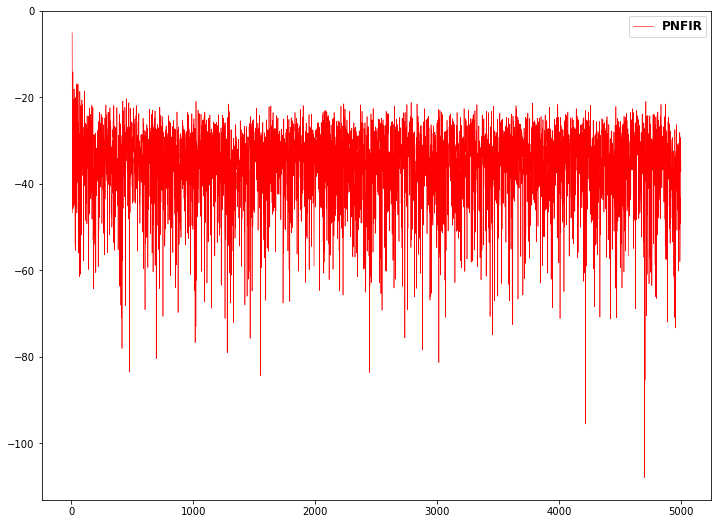

In [90]:
N = 5000; M=5; p=2; apoch=1
train_para=np.array([0.6,0.01,0.6,0,1e-4]) 
error2_sum_PNFIR=np.zeros(N);
error2_sum_PNFIR02=np.zeros(N);
for times in range(0,apoch): 
    x_raw,d_raw,d_noise=input_set(1,1,N,1)    #  random
    #x_raw,d_raw,d_noise=input_set(1,0,N,1)    #  gaussian
    output_filter,error_PNFIR,weight_lin,weght_non,value_a=PNFIR_model(x_raw,d_raw,M,p,train_para)  #PNFIR
    output_filter,error_PNFIR02,weight_lin,weght_non,value_a=PNFIR_model_zhao(x_raw,d_raw,M,p,train_para)  #PNFIR
    error2_sum_PNFIR+=error_PNFIR**2
    error2_sum_PNFIR02+=error_PNFIR02**2
    if(0==times%10):
        print('apoch:',times,'PNFIR',10*np.log10(np.mean(error_PNFIR[-100:]**2)),'dB',\
              10*np.log10(np.mean(error_PNFIR02[-100:]**2)),'dB'
             )
error2_sum_PNFIR/=apoch;
error2_sum_PNFIR02/=apoch;
print('apoch:',apoch,'\n','mean_MSE:','PNFIR',np.mean(error2_sum_PNFIR[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR[-106:-6])),'dB',\
     np.mean(error2_sum_PNFIR02[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR02[-106:-6])),'dB'
     )
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.show()

apoch: 0   -14.875125380481109
apoch: 50   -14.52209820089137
apoch: 99 mean_MSE: 0.042439415098841866


C:\Windows\Temp/ipykernel_23180/567584340.py:65: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N), 10*np.log10(error2_sum_NFIR), color='#37F500', label="SOV", linewidth=0.6)


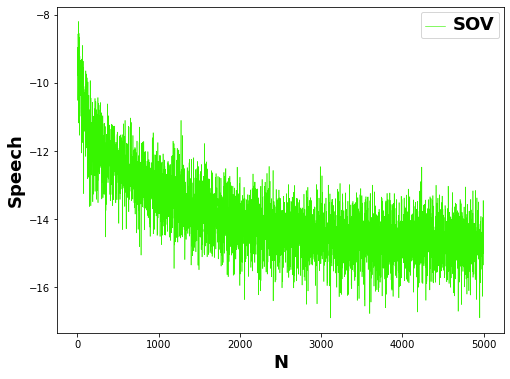

In [12]:
import numpy as np; import copy
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.random(input_len)
    elif(1==input_type): 
        input_raw=2*np.random.random(input_len)-1
    elif(2==input_type):
        input_raw=np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(1-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len))
    if(1==sys_no):
        for i in range(1,input_len): output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise

def NFIR_mode(input_data,desire_data,inputlen,train):
    weight = 0.001*np.random.random(inputlen)
    input_x = np.zeros(inputlen);
    output_y = np.zeros(N)
    error = np.zeros(N);
    for j in range(inputlen-1,len(input_data)):
        input_x[:]=input_data[j-inputlen+1:j+1]
        output_y[j] = np.dot(weight,input_x.T)
        output_y[j]=1./(1+np.exp((-1)*(copy.deepcopy(output_y[j]))))
        error[j] = desire_data[j]-output_y[j]
        dif_output_modul=( np.exp((-1)*(copy.deepcopy(output_y[j]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_y[j]))))*(1+np.exp((-1)*(copy.deepcopy(output_y[j])))) )
        weight[:] += train*error[j]*input_x[:]*dif_output_modul;
    return output_y,error 

N = 5000; apoch=100
error2_sum_NFIR=np.zeros(N); 
for times in range(0,apoch):
    x_raw,d_raw,d_noise=input_set(1,0,N,0) # Random Sequence
    output_filter,error2_NFIR=NFIR_mode(x_raw,d_noise,5, 0.1)  
    error2_sum_NFIR+=error2_NFIR**2;
    if(0==times%50):
        print('apoch:',times,' ',10*np.log10(np.mean(error2_NFIR[-201:]**2)))
error2_sum_NFIR/=apoch;
print('apoch:',times,'mean_MSE:',np.mean(error2_sum_NFIR)) 
import matplotlib as mpl;import matplotlib.pyplot as plt;import copy
import matplotlib.font_manager as fm;from matplotlib.ticker import MultipleLocator,AutoMinorLocator
plt.figure(figsize=(8, 6)); 
plt.xlabel("N",fontsize=18, fontweight='bold'); plt.ylabel("Speech",fontsize=18, fontweight='bold')
plt.plot(np.arange(N), 10*np.log10(error2_sum_NFIR), color='#37F500', label="SOV", linewidth=0.6)
plt.legend(loc=0, numpoints=1);leg = plt.gca().get_legend();ltext = leg.get_texts();plt.setp(ltext, fontsize=18, fontweight='bold')  # 设置图例字体的大小和粗细
plt.show()

In [45]:
value_a

2.58712481862501

apoch: 0 JPPSOV01  -31.5940194668833 dB
apoch: 50 JPPSOV01  -31.545485023753063 dB
apoch: 100 
 mean_MSE: JPPSOV01 0.0011410114895853331


C:\Users\Administrator\AppData\Local\Temp/ipykernel_2812/3306490210.py:104: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N), 10*np.log10(error2_sum_JPPSOV01), color='red',   label="JPPSOV01", linewidth=0.6)


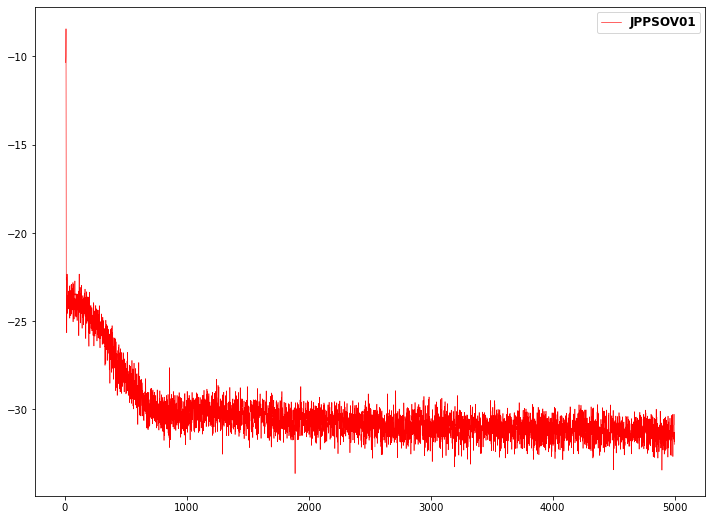

In [44]:
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.standard_normal(input_len)
    elif(1==input_type): 
        input_raw=np.random.random(input_len)
    elif(2==input_type):
        input_raw=0.325*np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
        input_raw=0.6*input_raw
    elif(4==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        for t in range(1,input_len):
            input_raw[t]=0.9*input_raw[t-1]#+0.1*white_noise[t] 
    elif(5==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        input_raw[1]=1.79*input_raw[0]+white_noise[1]
        input_raw[2]=1.79*input_raw[1]-1.85*input_raw[0]+white_noise[2]
        input_raw[3]=1.79*input_raw[2]-1.85*input_raw[1]+1.27*input_raw[0]+white_noise[3]
        for t in range(4,input_len):
            input_raw[t]=1.79*input_raw[t-1]-1.85*input_raw[t-2]+1.27*input_raw[t-3]-0.41*input_raw[t-4] \
            +white_noise[t]
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.5-0))/(input_raw_max-input_raw_min)
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.6-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len)) 
    if(1==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=(output_raw[i-1])/(1+output_raw[i-1]**2)+input_raw[i]**3
            #output_raw[i]=(1*output_raw[i-1])/(1+output_raw[i-1]**2)+ 1.3*input_raw[i]**2+ 1.0*input_raw[i-3]**2#0.5*(input_raw[i-3])
    elif(0==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def JPPSOV_model01(input_data,desire_data,M_num,p_num,train,sort):
    nonlin_input_len=p_num+1;
    nonlin_weight_len=int(1+(p_num+1)+(p_num+1)*(p_num+2)/2)
    weight_nonlin = 0.001*(np.random.random(nonlin_weight_len))
    weight_linear = 0.001*(np.random.random(M_num))
    input_module=np.zeros(nonlin_input_len); input_post = np.ones(nonlin_weight_len)
    output_modul = np.zeros(M_num); output_filter = np.zeros(len(input_data))
    error=np.zeros_like(input_data)
    for j in range(M_num+p_num-2+1,len(input_data)):
        temp_w_sum=np.zeros(nonlin_weight_len);
        for jj in range(0,M_num):
        #for jj in range(M_num-1,-1,-1):
            if(jj==(M_num-1)) : 
                if(1==sort):
                    input_module[0]=output_modul[jj]
                else:
                    input_module[0]=input_data[j-jj-1]
            else : 
                input_module[0]=output_modul[jj+1]
            for jjj in range(1,p_num+1):
                input_module[jjj]=input_data[j-jj-(jjj-1)]         
            input_post[1:1+nonlin_input_len]=input_module[:]; SOVlen=0
            for k in range(0,nonlin_input_len):
                for kk in range(k,nonlin_input_len):
                    input_post[1+nonlin_input_len+SOVlen]=input_module[k]*input_module[kk]
                    SOVlen=SOVlen+1
            output_modul[jj]=np.dot(weight_nonlin,input_post.T)
            temp_w_sum=temp_w_sum+weight_linear[jj]*input_post
        output_filter[j]=np.dot(weight_linear,output_modul.T)
        error[j] = desire_data[j] - output_filter[j]
        gama=train[0]
        weight_linear = weight_linear+train[1]*error[j]*output_modul/(gama+np.linalg.norm(output_modul)**2)
        weight_nonlin = weight_nonlin+train[2]*error[j]*temp_w_sum/(gama+np.linalg.norm(temp_w_sum)**2)     
    return output_filter,error,weight_linear,weight_nonlin
N = 5000; M=5; p=2; apoch=100
train_para_M5=np.array([1e-2,0.5,0.2]) 
error2_sum_JPPSOV01=np.zeros(N);
for times in range(0,apoch): 
    x_raw,d_raw,d_noise=input_set(1,1,N,1)    #  random
    output_filter,error_JPPSOV01,weight_lin,weght_non=JPPSOV_model01(x_raw,d_noise,M,p,train_para_M5,1) #JPPSOV01
    error2_sum_JPPSOV01+=error_JPPSOV01**2
    if(0==times%50):
        print('apoch:',times,'JPPSOV01 ',10*np.log10(np.mean(error_JPPSOV01[-200:]**2)),'dB')
error2_sum_JPPSOV01/=apoch;
print('apoch:',apoch,'\n','mean_MSE:','JPPSOV01',np.mean(error2_sum_JPPSOV01))
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N), 10*np.log10(error2_sum_JPPSOV01), color='red',   label="JPPSOV01", linewidth=0.6)
plt.legend(loc=0, numpoints=1);leg = plt.gca().get_legend();ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold');plt.show()

In [26]:
import numpy as np; import copy
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.standard_normal(input_len)
    elif(1==input_type): 
        input_raw=0.6*np.random.random(input_len)
    elif(2==input_type):
        input_raw=0.325*np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
        input_raw=0.6*input_raw
    elif(4==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        for t in range(1,input_len):
            input_raw[t]=0.9*input_raw[t-1]#+0.1*white_noise[t] 
    elif(5==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        input_raw[1]=1.79*input_raw[0]+white_noise[1]
        input_raw[2]=1.79*input_raw[1]-1.85*input_raw[0]+white_noise[2]
        input_raw[3]=1.79*input_raw[2]-1.85*input_raw[1]+1.27*input_raw[0]+white_noise[3]
        for t in range(4,input_len):
            input_raw[t]=1.79*input_raw[t-1]-1.85*input_raw[t-2]+1.27*input_raw[t-3]-0.41*input_raw[t-4] \
            +white_noise[t]
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.6-0))/(input_raw_max-input_raw_min)
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.6-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len)) 
    if(1==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=(output_raw[i-1])/(1+output_raw[i-1]**2)+input_raw[i]**3
            #output_raw[i]=(1*output_raw[i-1])/(1+output_raw[i-1]**2)+ 1.3*input_raw[i]**2+ 1.0*input_raw[i-3]**2#0.5*(input_raw[i-3])
    elif(0==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def PNFIR_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0.1
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        for ii in range(M_num-1,-1,-1):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
#         if(0==i%100): 
#             #print('output_modul:',output_modul[:,i])
#             print('dif_output_modul:',dif_output_modul)
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul[iiii]*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a
def PNFIR_model_zhao(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+1;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    value_a=0.1
    #weight_a=np.zeros(1)
    lambda_a=0
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_nonlin = np.zeros_like(output_modul);
    output_linear = np.zeros_like(input_data)
    output_filter = np.zeros_like(input_data)
    error = np.zeros_like(input_data)
    for i in range(M_num+p_num-1,len(input_data)):
        for ii in range(M_num-1,-1,-1):   # external_input(r) 
            if(ii==(M_num-1)):
                external_input[ii]=output_nonlin[0,i-1]
            else :
                external_input[ii]=output_nonlin[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_nonlin[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            #dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
            dif_output_modul=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_linear=np.dot(weight_linear,output_nonlin[:,i].T)
        lambda_a=1./(1+np.exp((-1)*(copy.deepcopy(value_a))))
        output_filter[i]=lambda_a*output_linear+(1-lambda_a)*(sum(output_modul[:,i]))     
        error[i]=desire_data[i-1] - output_filter[i]
        gama=train[4]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]*(lambda_a*dif_output_modul*weight_linear[iiii]+1-lambda_a);
            if(0==train[3]):
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
            else:
                weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]/(gama+np.linalg.norm(input_module_pd1[iiii,:])**2) 
        if(0==train[3]):
            weight_linear+=train[1]*error[i]*(output_nonlin[:,i]).T
        else:
            weight_linear+=train[1]*error[i]*((output_nonlin[:,i]).T)/(gama+np.linalg.norm(((output_nonlin[:,i]).T))**2)
        value_a+=train[2]*error[i]*(output_linear-(sum(output_modul[:,i])))*lambda_a*(1-lambda_a)
    return output_filter,error,weight_linear,weight_nonlin,value_a

apoch: 0 PNFIR -38.125290172548056 dB -37.72359628455344 dB
apoch: 50 PNFIR -38.482165535293326 dB -37.72359628455344 dB
apoch: 100 
 mean_MSE: PNFIR 0.00018935401114049483 -37.22725490660756 dB 0.0001708856612408283 -37.67294376748178 dB


C:\Windows\Temp/ipykernel_23180/3670879774.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)


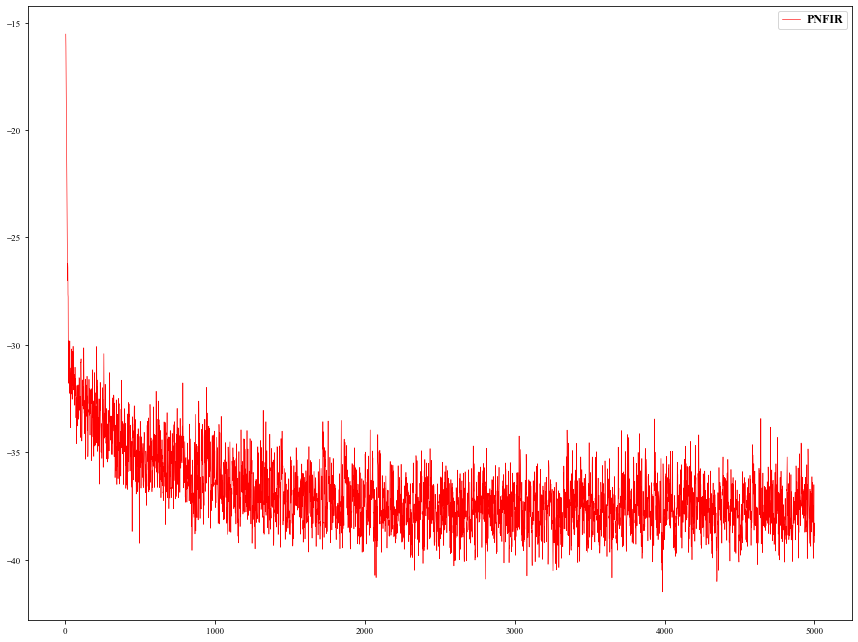

In [27]:
N = 5000; M=5; p=2; apoch=100
train_para=np.array([0.6,0.01,0.6,0,1e-4]) 
train_para=np.array([0.5,0.001,0.01,0,1e-4]) #  colored
error2_sum_PNFIR=np.zeros(N);
error2_sum_PNFIR02=np.zeros(N);
for times in range(0,apoch): 
    #x_raw,d_raw,d_noise=input_set(1,1,N,1)    #  random
    x_raw,d_raw,d_noise=input_set(1,5,N,1)    #  colored
    output_filter,error_PNFIR,weight_lin,weght_non,value_a=PNFIR_model(x_raw,d_raw,M,p,train_para)  #PNFIR
    #output_filter,error_PNFIR02,weight_lin,weght_non,value_a=PNFIR_model_zhao(x_raw,d_raw,M,p,train_para)  #PNFIR
    error2_sum_PNFIR+=error_PNFIR**2
    error2_sum_PNFIR02+=error_PNFIR02**2
    if(0==times%50):
        print('apoch:',times,'PNFIR',10*np.log10(np.mean(error_PNFIR[-100:]**2)),'dB',\
              10*np.log10(np.mean(error_PNFIR02[-100:]**2)),'dB'
             )
error2_sum_PNFIR/=apoch;
error2_sum_PNFIR02/=apoch;
print('apoch:',apoch,'\n','mean_MSE:','PNFIR',np.mean(error2_sum_PNFIR[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR[-106:-6])),'dB',\
     np.mean(error2_sum_PNFIR02[-106:-6]),10*np.log10(np.mean(error2_sum_PNFIR02[-106:-6])),'dB'
     )
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_PNFIR),color='red',label="PNFIR",linewidth=0.6)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.tight_layout();plt.show()

C:\Windows\Temp/ipykernel_23180/2318365353.py:28: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N), 10*np.log10(error2_sum_PNFIR), color='#1887F0',label="PNFIR",linewidth=0.6)


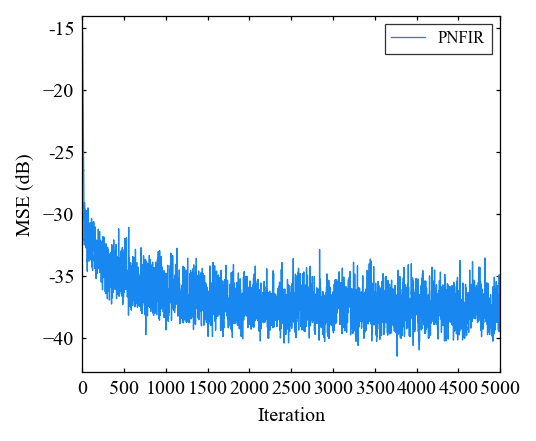

In [25]:
import matplotlib as mpl;import matplotlib.pyplot as plt;import copy
import matplotlib.font_manager as fm;from matplotlib.ticker import MultipleLocator,AutoMinorLocator
# 图片大小,单位厘米
fw = 8.69/2.54; fh = 7.18/2.54 
# 设置全局的字体
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.variant'] = 'normal'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.stretch'] ='normal'
mpl.rcParams['font.size'] = 9
font0 = {'fontfamily': 'serif',
         'fontname': 'Times New Roman',
         'fontstyle': 'normal',
         'fontvariant': 'normal',
         'fontweight': 'normal',
         'fontstretch': 'normal',
         'fontsize': 9}
tick_font = fm.FontProperties(family='Times New Roman', style='normal', variant='normal', weight='normal',
                           stretch='normal', size=9)

fig = plt.figure(figsize=(fw,fh),dpi=160);    
ax = fig.add_subplot(111)

#plt.plot(np.arange(N), 10*np.log10(error2_sum_PSOV), color='#F00CC5',label="PSOV",linewidth=0.6)
#plt.plot(np.arange(N), 10*np.log10(error2_sum_SOV), color='#37F500', label="SOV", linewidth=0.6)
plt.plot(np.arange(N), 10*np.log10(error2_sum_PNFIR), color='#1887F0',label="PNFIR",linewidth=0.6)

ax.set_xlim(0,N); #ax.set_ylim(-35,-5);
ax.tick_params(which='major',length=2,width=0.57,bottom=True, top=True, left=True, right=True);
ax.tick_params(which='minor',length=1.7,width=0.57,bottom=True, top=True, left=True, right=True)
ax.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
ax.tick_params(axis="both", which='both', direction="in") 
ax.xaxis.set_major_locator(MultipleLocator(base=1000))
ax.xaxis.set_minor_locator(MultipleLocator(base=500))
ax.xaxis.set_minor_formatter((mpl.ticker.FormatStrFormatter('%.0f')))
ax.yaxis.set_major_locator(MultipleLocator(base=10))
ax.yaxis.set_minor_locator(MultipleLocator(base=5))
ax.yaxis.set_minor_formatter((mpl.ticker.FormatStrFormatter('%.0f')))
# 设置tick_label字体
for xtlabel in ax.get_xticklabels():
    xtlabel.set_fontproperties(tick_font)
for ytlabel in ax.get_yticklabels():
    ytlabel.set_fontproperties(tick_font)
# 设置图形变宽线宽度和颜色
bwith = 0.57
ax.spines['left'].set_color((0,0,0,1))
ax.spines['left'].set_linewidth(bwith)
ax.spines['right'].set_color((0,0,0,1))
ax.spines['right'].set_linewidth(bwith)
ax.spines['top'].set_color((0,0,0,1))
ax.spines['top'].set_linewidth(bwith)
ax.spines['bottom'].set_color((0,0,0,1))
ax.spines['bottom'].set_linewidth(bwith)
# 设置图形坐标轴标签和标题字体
ax.set_xlabel('Iteration',fontdict=font0)  
ax.set_ylabel('MSE (dB)',fontdict=font0)  
ax.legend(loc='upper right',frameon=True,edgecolor='black',facecolor='white',\
          shadow=False,fancybox=False,fontsize='small').get_frame().set_linewidth(0.57) 
plt.tight_layout()   
#fig.savefig('D:\\Postgraduatee\\sketch\photo\\S6dot25\\sys_exp_random.PNG', bbox_inches='tight', dpi=1200)
plt.show();